<a href="https://colab.research.google.com/github/bzhanglab/AutoRT/blob/master/example/Experiment_specific_RT_prediction_using_AutoRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment-specific RT prediction using AutoRT

In this notebook, I will walk you through an example about highly accurate experiment-specific RT prediction using transfer learning strategy in AutoRT using a small training data (5141 peptides) from a global proteome experiment. This is how users should use AutoRT in most cases.If there are variable modifications other than Oxidation on M in your dataset, you have to retrain the base model used by AutoRT in transfer learning.

### Installation

#### Run AutoRT on local computer

Only run the following code when run this notebook on local computer. Make sure all the dependent libraries and packages are installed successfully. 

In [ ]:
## install cuda library for tensorflow 2.6
! conda install cudatoolkit=11.2
! conda install -c fastchan cudnn=8.1.0.77

## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
! pip install -r AutoRT/requirements.txt

#### Run AutoRT on Google Colab

Only run the following code when run this notebook on Google Colab. Colab already has all the dependent libraries and packages installed, so we only need to download AutoRT from github.

In [ ]:
## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
% cd /content/

Cloning into 'AutoRT'...
remote: Enumerating objects: 388, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 388 (delta 4), reused 5 (delta 1), pack-reused 376
Receiving objects: 100% (388/388), 1.32 GiB | 30.02 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Checking out files: 100% (85/85), done.
total 8
drwxr-xr-x 6 root root 4096 Oct 10 21:22 AutoRT
drwxr-xr-x 1 root root 4096 Sep 30 17:12 sample_data


### Example dataset

In this example, we will use a dataset used in the original AutoRT paper. It is from a label free dataset and all the peptides are from a single fraction. For MS/MS searching, a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M) were used. Since all C amino acids were modified, we don't need to encode modified C in AutoRT. For amino acid M, there should have two versions in the dataset, so we need to encode modified M and unmodified M. We use "M" to represent unmodified M and use "1" to represent modified M (Oxidation [M]).This should be consistent with the encoding for modifications in the training data used for base models.

The example data is in the folder **AutoRT/example/**: data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv

Go to the folder **AutoRT/example/**:

In [ ]:
## go to the folder example
%cd AutoRT/example/

/content/AutoRT/example


Check all the data in the foler **AutoRT/example/**:

In [ ]:
! ls -l

total 384
drwxr-xr-x 2 root root   4096 Oct 10 21:22 data
-rw-r--r-- 1 root root 380413 Oct 10 21:22 Experiment_specific_RT_prediction_using_AutoRT.ipynb
-rw-r--r-- 1 root root    385 Oct 10 21:22 train_model_from_scratch.sh
-rw-r--r-- 1 root root    362 Oct 10 21:22 transfer_learning.sh


In [ ]:
import pandas as pd
train_data = pd.read_csv("data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv",sep="\t")
print("The number of unique peptides in the training data: %d" % (train_data.shape[0]))
train_data.head()

The number of unique peptides in the training data: 5141


,x,y
0,1APYQGPDAVPGALDYK,37.797092
1,1CCCSYNIGR,18.298540
2,1CFNYEIR,28.325425
3,1FLGDNAHLSIINEYLSQSYQK,61.661926
4,1GYAEEAPYDAIHVGAAAPVVPQALIDQLKPGGR,64.956116


RT distribution in the training data is shown below. The unit of the RT in the data is minute.

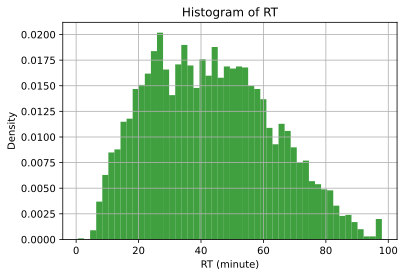

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# the histogram of the data
plt.hist(train_data['y'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('RT (minute)')
plt.ylabel('Density')
plt.title('Histogram of RT')
plt.grid(True)
plt.show()


### Training


#### Base model:
The trained base model used here is available at **AutoRT/models/base_models_PXD006109/**. The base model was trained using a large dataset which contains more than 100,000 peptides.The training data for the base model training only contains a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M).We encoded modified M (Oxidation) using "1".

#### Experiment-specific RT model training:
Below is the command line for training using transfer learning strategy.


In [ ]:
! python ../autort.py train -i data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv -o tf_model/ -e 40 -b 64 -u m -m ../models/general_base_model/model.json -rlr -n 10

Scaling method: min_max
Step 1:

Load aa coding data from file ../models/general_base_model/aa.tsv
AA types: 25
Longest peptide in training data: 41

Use test file tf_model//step1/validation.tsv
Longest peptide in test data: 30

['1', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
RT range: 0 - 98

X_train shape:
(4626, 60)
X_test shape:
(515, 60)
Modeling start ...
Use one GPU or no GPU!

Model training: 0
2021-10-10 21:23:05.777426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 21:23:06.253358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 21:23:06.254259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successf

After the training is done, the trained model is in the folder **tf_model/** (-o):

In [ ]:
! ls -l tf_model/

total 196380
-rw-r--r-- 1 root root      120 Oct 10 21:36 aa.tsv
-rw-r--r-- 1 root root 20405264 Oct 10 21:26 model_0.h5
-rw-r--r-- 1 root root 18264536 Oct 10 21:27 model_1.h5
-rw-r--r-- 1 root root 20559088 Oct 10 21:27 model_2.h5
-rw-r--r-- 1 root root 20559064 Oct 10 21:29 model_3.h5
-rw-r--r-- 1 root root 20405280 Oct 10 21:30 model_4.h5
-rw-r--r-- 1 root root 20251888 Oct 10 21:31 model_5.h5
-rw-r--r-- 1 root root 20558880 Oct 10 21:33 model_6.h5
-rw-r--r-- 1 root root 20251664 Oct 10 21:33 model_7.h5
-rw-r--r-- 1 root root 19557368 Oct 10 21:34 model_8.h5
-rw-r--r-- 1 root root 19557392 Oct 10 21:36 model_9.h5
-rw-r--r-- 1 root root      532 Oct 10 21:36 model_all.json
-rw-r--r-- 1 root root      605 Oct 10 21:43 model.json
-rw-r--r-- 1 root root   112633 Oct 10 21:43 models_combination_metrics.tsv
-rw-r--r-- 1 root root   158685 Oct 10 21:24 new_train_data.tsv
drwxr-xr-x 4 root root     4096 Oct 10 21:24 step1
-rw-r--r-- 1 root root    15099 Oct 10 21:36 test_0.csv
-rw-r--r-- 1

### Prediction

There is a testing dataset in the same folder **AutoRT/example/**:data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv.

The column **x** is required which contains the peptides. The column "y" is not required.

In [ ]:
test_data = pd.read_csv("data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv",sep="\t")
test_data.head()

,x,y
0,LINNNPEIFGPLK,46.334335
1,VGDTYERPK,11.445240
2,TSRPENAIIYNNNEDFQVGQAK,33.492008
3,KQNVVPTVLALGSDVD1DVLTTLSLGDR,83.955305
4,IVASTLSNPELFEEWTGNVK,64.316923


In [ ]:
! python ../autort.py predict -t data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv -s tf_model/model.json -o tf_prediction/ -p test

Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 25
Longest peptide in input data: 35

['1', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

Deep learning model: 0
2021-10-10 21:44:20.821016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 21:44:20.848009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 21:44:20.848884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 21:44:20.850629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA 

The prediction result is in the file **tf_prediction/test.tsv**. The values in the column **y_pred** are predicted RT. Other files in the same folder are intermediate files which are not useful to users. 

In [ ]:
! ls -l tf_prediction/

total 164
-rw-r--r-- 1 root root 17338 Oct 10 21:44 test_0.csv
-rw-r--r-- 1 root root  2416 Oct 10 21:44 test_0.npy
-rw-r--r-- 1 root root 17358 Oct 10 21:44 test_1.csv
-rw-r--r-- 1 root root  2416 Oct 10 21:44 test_1.npy
-rw-r--r-- 1 root root 17319 Oct 10 21:44 test_5.csv
-rw-r--r-- 1 root root  2416 Oct 10 21:44 test_5.npy
-rw-r--r-- 1 root root 17322 Oct 10 21:44 test_7.csv
-rw-r--r-- 1 root root  2416 Oct 10 21:44 test_7.npy
-rw-r--r-- 1 root root 17326 Oct 10 21:44 test_8.csv
-rw-r--r-- 1 root root  2416 Oct 10 21:44 test_8.npy
-rw-r--r-- 1 root root 17223 Oct 10 21:44 test_evaluate.csv
-rw-r--r-- 1 root root 23769 Oct 10 21:44 test.tsv


Now we can look at the performance of the RT prediction.

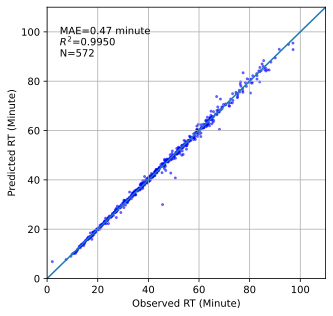

In [ ]:
import sklearn
import scipy
from sklearn.model_selection import train_test_split


pred_data = pd.read_csv("tf_prediction/test.tsv",sep="\t")
pred_data.head()

cor = scipy.stats.pearsonr(pred_data['y'], pred_data['y_pred'])[0]
mae = sklearn.metrics.median_absolute_error(pred_data['y'], pred_data['y_pred'])
r2 = sklearn.metrics.r2_score(pred_data['y'], pred_data['y_pred'])

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(pred_data['y'], pred_data['y_pred'],s=4, c="blue", alpha=0.5)
plt.text(5, 90, "MAE="+"{:.2f}".format(mae)+" minute\n$R^2$="+"{:.4f}".format(r2)+"\nN="+str(pred_data.shape[0]))
plt.plot( [0,110],[0,110] )
plt.xlabel('Observed RT (Minute)')
plt.ylabel('Predicted RT (Minute)')
plt.xlim(0,110)
plt.ylim(0,110)
plt.grid(True)
plt.show()